In [1]:
%matplotlib inline
import sys
sys.path.append('/Users/pradap/Documents/Research/Python-Package/anhaid/py_entitymatching/')

In [2]:
import py_entitymatching as em
import profiler
import pandas as pd
import qgrid

In [3]:
## Read input tables
A = em.read_csv_metadata('dblp_demo.csv', key='id')
B = em.read_csv_metadata('acm_demo.csv', key='id')

Number of unique values: 10
Number of missing values: 0

Unique values:
[1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003]

Frequency plot:



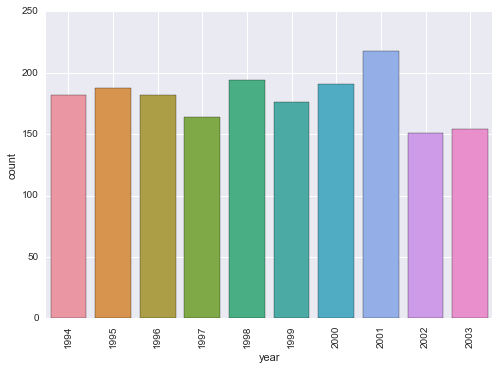

In [4]:
profiler.profile_table(A, 'year')

Number of unique values: 11
Number of missing values: 0

Unique values:
[1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 20003]

Frequency plot:



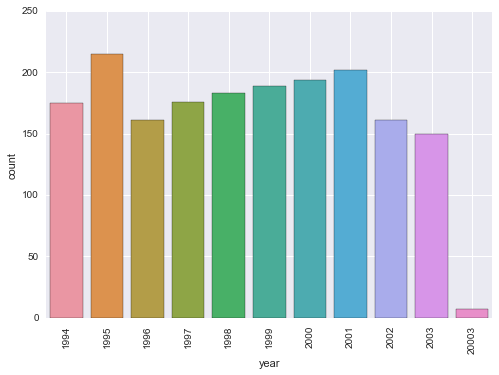

In [5]:
profiler.profile_table(B, 'year')

In [6]:
B.replace({'year':{
            20003:2003
        }}, inplace=True)

In [7]:
# Create attribute equivalence blocker
ab = em.AttrEquivalenceBlocker()
# Block tables using 'year' attribute : same year include in candidate set
C1 = ab.block_tables(A, B, 'year', 'year', 
                     l_output_attrs=['title', 'authors', 'year'],
                     r_output_attrs=['title', 'authors', 'year']
                    )
len(C1)

328781

In [8]:
# check whether the current blocking method has dropped a lot of potential matches
# dbg = em.debug_blocker(C1, A, B)

In [9]:
# add year attribute to the debugger output - 
#[This will change in the actual VLDB demo. Specifically, this will be embedded in debug blocker]
# em.set_ltable(dbg, A)
# em.set_rtable(dbg, B)
# dbg = em.add_output_attributes(dbg, l_output_attrs=['year'], r_output_attrs=['year'])


In [10]:
# Initialize overlap blocker
ob = em.OverlapBlocker()
# Block over title attribute
C2 = ob.block_tables(A, B, 'title', 'title', show_progress=False, overlap_size=2)
len(C2)

44052

In [11]:
# Combine the outputs from attr. equivalence blocker and overlap blocker
C = em.combine_blocker_outputs_via_union([C1, C2])
len(C)

366315

In [12]:
# # Check again to see if we are dropping any potential matches
# dbg = em.debug_blocker(C, A, B)
# em.set_ltable(dbg, A)
# em.set_rtable(dbg, B)
# dbg = em.add_output_attributes(dbg, l_output_attrs=['year'], r_output_attrs=['year'])

In [13]:
# dbg.head()

In [14]:
import mur_utils as mu

In [15]:
L = em.read_csv_metadata('labeled_data_demo.csv', ltable=A, rtable=B)

In [16]:
# Split L into development  and evaluation
development_evaluation = em.split_train_test(L, train_proportion=0.7, random_state=0) # fix the random seed
development = development_evaluation['train']
evaluation = development_evaluation['test']

In [17]:
# Create a set of ML-matchers
dt = em.DTMatcher(name='DecisionTree', random_state=0)
svm = em.SVMMatcher(name='SVM', random_state=0)
rf = em.RFMatcher(name='RF', random_state=0)
nb = em.NBMatcher(name='NB')
lg = em.LogRegMatcher(name='LogReg', random_state=0)
ln = em.LinRegMatcher(name='LinReg')

In [18]:
# Generate features
feature_table = em.get_features_for_matching(A, B)

In [19]:
# List the feature names generated
feature_table['feature_name']

0                          id_id_lev_dist
1                           id_id_lev_sim
2                               id_id_jar
3                               id_id_jwn
4                               id_id_exm
5                   id_id_jac_qgm_3_qgm_3
6             title_title_jac_qgm_3_qgm_3
7         title_title_cos_dlm_dc0_dlm_dc0
8                         title_title_mel
9                    title_title_lev_dist
10                    title_title_lev_sim
11        authors_authors_jac_qgm_3_qgm_3
12    authors_authors_cos_dlm_dc0_dlm_dc0
13                    authors_authors_mel
14               authors_authors_lev_dist
15                authors_authors_lev_sim
16            venue_venue_jac_qgm_3_qgm_3
17        venue_venue_cos_dlm_dc0_dlm_dc0
18        venue_venue_jac_dlm_dc0_dlm_dc0
19                        venue_venue_mel
20                   venue_venue_lev_dist
21                    venue_venue_lev_sim
22                        venue_venue_nmw
23                         venue_v

In [20]:
# Select all features, except the id related ones
feature_table_iter1 = feature_table

In [21]:
# Extract feature vectors
feature_vectors_dev_iter1 = em.extract_feature_vecs(development, 
                            feature_table=feature_table_iter1, 
                            attrs_after='label',
                            show_progress=False) 

In [23]:
# Select the best ML matcher using CV
result = em.select_matcher([dt, rf, svm, nb, lg, ln], table=feature_vectors_dev_iter1, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'label'],
        k=5,
        target_attr='label', metric='f1', random_state=0)

In [24]:
result['cv_stats']

,Name,Matcher,Num folds,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5,Mean score
0,DecisionTree,<py_entitymatching.matcher.dtmatcher.DTMatcher object at 0x1154346a0>,5,0.926829,0.871795,0.958333,0.979592,1.0,0.947310
1,RF,<py_entitymatching.matcher.rfmatcher.RFMatcher object at 0x1154344e0>,5,0.974359,0.972973,0.978723,1.000000,1.0,0.985211
2,SVM,<py_entitymatching.matcher.svmmatcher.SVMMatcher object at 0x115434438>,5,0.888889,0.882353,0.800000,0.956522,0.9,0.885553
3,NB,<py_entitymatching.matcher.nbmatcher.NBMatcher object at 0x115434fd0>,5,0.926829,0.972973,0.978723,1.000000,1.0,0.975705
4,LogReg,<py_entitymatching.matcher.logregmatcher.LogRegMatcher object at 0x115434c18>,5,0.926829,0.900000,0.978723,1.000000,1.0,0.961111
5,LinReg,<py_entitymatching.matcher.linregmatcher.LinRegMatcher object at 0x118554c50>,5,0.974359,0.972973,0.978723,1.000000,1.0,0.985211


In [25]:
# Debug RF

# Split feature vectors to train and test
train_test = em.split_train_test(feature_vectors_dev_iter1, train_proportion=0.5, random_state=0)
train = train_test['train']
test = train_test['test']

In [26]:
ll = (set(development.ltable_id.values).intersection(test.ltable_id.values))
ll = sorted(ll)

In [54]:
ll[0:40]

['l1009',
 'l1011',
 'l1015',
 'l102',
 'l1022',
 'l1028',
 'l103',
 'l1066',
 'l108',
 'l1080',
 'l1083',
 'l1087',
 'l1126',
 'l113',
 'l114',
 'l1144',
 'l1147',
 'l1157',
 'l1160',
 'l1174',
 'l1183',
 'l1184',
 'l1189',
 'l120',
 'l123',
 'l1250',
 'l1266',
 'l1285',
 'l1304',
 'l1314',
 'l1317',
 'l1318',
 'l1331',
 'l1345',
 'l136',
 'l1365',
 'l1368',
 'l1371',
 'l1385',
 'l1392']

In [59]:
A1 = A.set_index('id', drop=False)

In [60]:
swap_list = ['l1009', 'l1066', 'l1022', 'l1080', 'l114', 'l1147', 'l1160', 'l1183', 'l1189', 'l120', 'l1331']


In [61]:
t = A1.ix[swap_list, 'title']
a = A1.ix[swap_list, 'authors']
A1.ix[swap_list, 'title'] = a
A1.ix[swap_list, 'authors'] = t


In [62]:
A1.ix[swap_list]

,id,title,authors,venue,year
id,,,,,
l1009,l1009,Description logics for semantic query optimization in object-oriented database systems,"Claudio Sartori, Sonia Bergamaschi, Domenico Beneventano",ACM Trans. Database Syst.,2003
l1066,l1066,An Overview of Data Warehousing and OLAP Technology,"Surajit Chaudhuri, Umeshwar Dayal",SIGMOD Record,1997
l1022,l1022,Energy and rate based MAC protocol for wireless sensor networks,"Ramaraju Kalidindi, Vijay Kumar, Rajgopal Kannan, S. Sitharama Iyengar",SIGMOD Record,2003
l1080,l1080,"Dan Suciu, Daniela Florescu, Alon Y. Levy, Mary F. Fernandez",A Query Language for a Web-Site Management System,SIGMOD Record,1997
l114,l114,Jef Wijsen,Temporal FDs on Complex Objects,ACM Trans. Database Syst.,1999
l1147,l1147,Xiaolei Qian,Scientist's Called Upon to Take Actions,SIGMOD Record,1996
l1160,l1160,"Khaled Alsabti, Vineet Singh, Sanjay Ranka",A One-Pass Algorithm for Accurately Estimating Quantiles for Disk-Resident Data,VLDB,1997
l1183,l1183,"Stephen Blott, Roger Weber, Hans-Jrg Schek",A Quantitative Analysis and Performance Study for Similarity-Search Methods in High-Dimensional ...,VLDB,1998
l1189,l1189,"Weimin Du, Xiangning Liu, Abdelsalam Helal",Multiview Access Protocols for Large-Scale Replication,ACM Trans. Database Syst.,1998


In [56]:
em.filter_rows(L, "ltable_id=='l1331'")

,_id,ltable_id,rtable_id,ltable_title,ltable_authors,ltable_year,rtable_title,rtable_authors,rtable_year,label
374,374,l1331,r1629,Object Fusion in Mediator Systems,"Yannis Papakonstantinou, Hector Garcia-Molina, Serge Abiteboul",1996,Object Fusion in Mediator Systems,"Yannis Papakonstantinou, Serge Abiteboul, Hector Garcia-Molina",1996,1


In [63]:
em.set_key(A1, 'id')
em.to_csv_metadata(A1, './dblp_demo_swap_11.csv')

True